[View in Colaboratory](https://colab.research.google.com/github/abhiksark/MajorProject/blob/master/dirty%20implementation%20.ipynb)

In [0]:
!pip install -U -q PyDrive

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import files
uploaded = files.upload()
!pip install -U -q PyDrive ## you will have install for every colab session




Saving kaggle.json to kaggle.json


In [10]:
!mkdir /content/.kaggle
#!mv /content/.kaggle kaggle.json
#!ls
#!chmod 600 ~ kaggle.json
!mv kaggle.json /content/.kaggle
!ls /content/.kaggle/
!chmod 600 ~ /content/.kaggle/kaggle.json


mkdir: cannot create directory ‘/content/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
kaggle.json


In [11]:
!pip install kaggle
!kaggle competitions list -s health
!kaggle competitions download -c diabetic-retinopathy-detection -p datalab

ref                                        deadline             category      reward  teamCount  userHasEntered  
-----------------------------------------  -------------------  --------  ----------  ---------  --------------  
hhp                                        2013-04-04 07:00:00  Featured    $500,000       1353           False  
ultrasound-nerve-segmentation              2016-08-18 23:59:00  Featured    $100,000        923           False  
diabetic-retinopathy-detection             2015-07-27 23:59:00  Featured    $100,000        661            True  
msk-redefining-cancer-treatment            2017-10-02 23:59:00  Research     $15,000       1386           False  
second-annual-data-science-bowl            2016-03-14 23:59:00  Featured    $200,000        773           False  
melbourne-university-seizure-prediction    2016-12-01 23:59:00  Research     $20,000        478           False  
data-science-bowl-2017                     2017-04-12 23:59:00  Featured  $1,000,000    

train.zip.004: Downloaded 8GB of 8GB
train.zip.002: Downloaded 8GB of 8GB


train.zip.001: Downloaded 8GB of 8GB
train.zip.005: Downloaded 1GB of 1GB
train.zip.003: Downloaded 8GB of 8GB


test.zip.004: Downloaded 8GB of 8GB
test.zip.005: Downloaded 8GB of 8GB


test.zip.002: Downloaded 8GB of 8GB
test.zip.003: Downloaded 8GB of 8GB


test.zip.001: Downloaded 8GB of 8GB
test.zip.006: Downloaded 8GB of 8GB
test.zip.007: Downloaded 3GB of 3GB


In [12]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-4).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [0]:
%%capture
!7z x datalab/train.zip.001

In [14]:
!ls train | head -4

10003_left.jpeg
10003_right.jpeg
10007_left.jpeg
10007_right.jpeg
ls: write error: Broken pipe


In [8]:
"""from google.colab import files
for i in range(11,59):
  try:
    files.download("train/100"+str(int(i))+"_left.jpeg")
    files.download("train/100"+str(int(i))+"_right.jpeg")
  except:
     pass"""

'from google.colab import files\nfor i in range(11,59):\n  try:\n    files.download("train/100"+str(int(i))+"_left.jpeg")\n    files.download("train/100"+str(int(i))+"_right.jpeg")\n  except:\n     pass'

In [0]:
import numpy as np # linear algebra
import pandas as pd 
import os

In [16]:
!unzip datalab/trainLabels.csv.zip

Archive:  datalab/trainLabels.csv.zip
  inflating: trainLabels.csv         


In [17]:
trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


array([0, 1, 2, 4, 3])

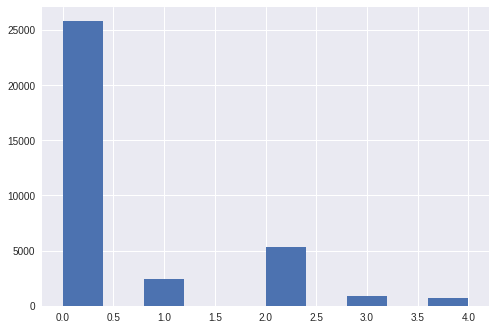

In [18]:
trainLabels["level"].hist()
trainLabels["level"].unique()

In [19]:
listing = os.listdir("train") 
len(listing)

35126

In [0]:
listing_test=listing[:5000]
listing_val=listing[5000:7000]


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 19 23:09:09 2018

@author: abhik
"""

import cv2 as cv
import numpy as np
import math

# Standard resolution of images after processing.
STD_RES = 756

# Thresholding parameter.
THRESH = 30  # For edge detection

# Canny edge detection parameters.
LOW_THRESH = 0
MAX_THRESH = 255
KERNEL = 3

# Hough Circle Transform parameters.
DP = 2  # Inverse accumulator ratio.
MD = STD_RES  # Minimum distance between circles.
P1 = 140
P2 = 30
MIN_R = int(STD_RES * 0.4)
MAX_R = STD_RES

# Blob detection parameters (for notch detection).
BLOB_PARAMS = cv.SimpleBlobDetector_Params()
BLOB_PARAMS.minThreshold = 0.0
BLOB_PARAMS.maxThreshold = THRESH
BLOB_PARAMS.thresholdStep = THRESH / 2
BLOB_PARAMS.filterByArea = False
BLOB_PARAMS.filterByColor = False
BLOB_PARAMS.filterByConvexity = False
BLOB_PARAMS.filterByInertia = True
BLOB_PARAMS.minInertiaRatio = 0.05
BLOB_PARAMS.maxInertiaRatio = 1


def preprocess_image(path):
    """
    Loads an image, converts to grayscale, flips the image if necessary based
    on which eye it is and if there is a notch present, and equalizes the
    image's histogram.
    :param str path: Path to an image.
    :rtype: numpy.ndarray
    """
    # Loading the image also converts it to grayscale.
    img = load_image(path)
    img_thresh = threshold(img)

    # Two-part notch-detection. Notch could be in upper-right quadrant, or it
    # could be in the bottom-right quadrant. Try the upper-right corner first -
    # if it's not there, try the bottom-right. If still no notch is detected,
    # assume there is no notch present and do no inversion.
    if detect_notch(img, img_thresh):
        cv.flip(img, -1, img)
        print("Notch detected in image {}.".format(path.split('/')[-1]))
    else:
        vert_flip = cv.flip(img, 0)
        vert_flip_thresh = cv.flip(img_thresh, 0)

        if detect_notch(vert_flip, vert_flip_thresh):
            cv.flip(img, -1, img)
            print("Notch detected in image {}.".format(path.split('/')[-1]))

    # Examine the file name and flip the eye horizontally if it's a left eye.
    if "left" in path:
        cv.flip(img, 1, img)

    # Finally, equalize the image.
    cv.equalizeHist(img, img)

    return img


def load_image(path, grayscale=True, equalize=False, resize=True):
    """
    Loads an image, transforms it to grayscale, and resizes it. Optionally
    equalizes the image's histogram. Equalization seems to play poorly with
    preprocessing however, so by default it is turned off.
    :param path: Path to the image file.
    :param grayscale: Flag for converting image to grayscale.
    :param equalize: Flag for equalizing the image's histogram.
    :param resize: Flag for resizing the image to standard resolution.
    :rtype: np.ndarray
    """

    img_in = cv.imread(path, cv.IMREAD_GRAYSCALE if grayscale else -1)
    if equalize:
        cv.equalizeHist(img_in, img_in)

    if resize:
        img_in = bb_resize(img_in, threshold(img_in))

    return img_in


def threshold(img):
    """ Thresholds image according to global parameter. """
    _, output = cv.threshold(img, THRESH, 255, cv.THRESH_BINARY)
    return output


def hough_circles(img):
    """
    Apply Hough Circle Transform using global parameters and returns data in
    a nice list-of-tuples format. If no circles are found, the empty list is
    returned.
    :param np.ndarray img: The image to search for circles.
    :returns: List of tuples of the form (x, y, radius)
    :rtype: list[(int, int, float)]
    """
    global DP, MD, P1, P2, MIN_R, MAX_R
    img = img.copy()

    # Black out the NW, SW, and SE quadrants to force Hough detection to align
    # to notch edge. This is done to hopefully reduce the amount of "edge" that
    # is left over after subtraction.
    h, w = img.shape
    half_h, half_w = (int(h / 2), int(w / 2))
    cv.rectangle(img, (0, 0), (half_w, h),
                 (0, 0, 0), thickness=cv.FILLED)
    cv.rectangle(img, (0, h), (w, half_h),
                 (0, 0, 0), thickness=cv.FILLED)

    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, DP, MD,
                              param1=P1, param2=P2,
                              minRadius=MIN_R, maxRadius=MAX_R)

    output = []
    if circles is not None:
        circles = circles[0]  # Why are tuples buried like this? Bug?
        for c in circles[0:]:
            output.append((c[0], c[1], c[2]))

    return output


def bb_resize(img, img_thresh):
    """
    Resizes an image using bounding boxes. This is done by thresholding the
    image and then calculating its bounding box. The shorter dimension of the
    bounding box is then expanded (with black pixels) to make the bounding box
    square. The pixels in the bounding box are moved to a new image, which is
    then resized to a standard resolution.
    This effect of this process should be that any eyeball image is roughly
    centered at the same position and about the same size. This is important for
    notch detection so that a small square can be placed approximately over
    where the notch should be in a standardized image.
    """
    x, y, w, h = cv.boundingRect(img_thresh)

    # If no bounding rectangle was able to be formed, then the image is
    # probably completely unusable. Simply resize to standard resolution and
    # move on.
    if (w == 0) or (h == 0):
        return cv.resize(img, (STD_RES, STD_RES), interpolation=cv.INTER_AREA)

    # Destination canvas is square, length of max dimension of the bb.
    max_wh = max(w, h)
    img_expand = np.zeros((max_wh, max_wh), dtype=np.uint8)

    # Copy the bounding box (region of interest) into the center of the
    # destination canvas. This will produce black bars on the short side.
    diff_w = max_wh - w
    diff_h = max_wh - h
    half_dw = int(math.floor(diff_w / 2.0))
    half_dh = int(math.floor(diff_h / 2.0))
    roi = img[y:y + h, x:x + w]
    img_expand[half_dh:(half_dh + h), half_dw:(half_dw + w)] = roi

    # Resize to our standard resolution.
    return cv.resize(img_expand, (STD_RES, STD_RES), interpolation=cv.INTER_AREA)


def detect_notch(img, img_thresh):
    """
    Detects if a notch is present in the image, and if so, returns True.
    First, the Hough Circle Transform is applied to find a circle corresponding
    to the entire eyeball. This circle is subtracted from the thresholded
    image of the eyeball. Ideally what is left at this point will be either
    a notch, or nothing. Since we will likely pick up "shreds" left from the
    edges of the subtraction, we contract and dilate at this point to remove
    leftovers.
    A region of interest is positioned over where notches appear usually,
    which is at about the 45 degree mark on the eyeball in the NE quadrant.
    Blob detection is run over this ROI. If a blob is detected, it is assumed
    that the blob is a notch, and the function can return True.
    """
    circles = hough_circles(img)

    # Paint out the first circle detected. Assume that only one circle was
    # detected for whole image. If no circles are detected, fail fast and just
    # return false.
    if circles:
        x, y, r = circles[0]
        cv.circle(img_thresh, (x, y), r, (0, 0, 0), cv.FILLED)
    else:
        return False

    # Erode what's left to try and remove edges.
    img_thresh = cv.erode(img_thresh, np.ones((3, 3), np.uint8))
    img_thresh = cv.dilate(img_thresh, np.ones((3, 3), np.uint8))

    # Extract a region of interest that is very likely to contain the notch if
    # one is present in the image. This corresponds to a small square at about
    # the 45 degree mark on the eyeball. Some notches are slightly lower than
    # this, so the ROI should be large enough to capture many notch positions.
    ratio = 1.0 / 4.0
    roi_size = img_thresh.shape[0] * ratio
    half_rs = roi_size / 2.0

    # Do a little trig to find cartesian coordinates of 45 degrees point.
    radius = img_thresh.shape[0] / 2.0
    angle = math.pi / 4.0
    side = radius * math.sin(angle)

    # Get the damned ROI.
    x, y = (int(radius + side - half_rs), int(radius - side - half_rs))
    roi = img_thresh[y:int(y + roi_size), x:int(x + roi_size)]

    # Run blob detection on what's left.
    sbd = cv.SimpleBlobDetector_create(BLOB_PARAMS)
    keypoints = sbd.detect(roi)

    # If keypoints were found, then we assume that a notch was detected.
    return bool(keypoints)


def draw_hough_circles(img, circles):
    """
    Creates new image from img with circles drawn over it. Will convert the
    output image to RGB space.
    :param np.ndarray img:
    :param list[(int, int, float)] circles: Detected circles.
    :rtype: np.ndarray
    """
    if circles:
        output = cv.cvtColor(img.copy(), cv.COLOR_GRAY2RGB)
        for c in circles:
            x, y, r = c
            cv.circle(output, (x, y), r, (0, 0, 255), 2)
    else:
        output = img

    return output


def experiment_threshold(path):
    """
    Launches experiment window for thresholding.
    :param str path: Path to the experiment image file.
    """
    img = load_image(path)
    _, thresh_img = cv.threshold(img, THRESH, 255, cv.THRESH_BINARY)

    # Image windows for this experiment.
    t_window = "Threshold Experiment"
    o_window = "Original Image"
    cv.namedWindow(t_window, cv.WINDOW_AUTOSIZE)
    cv.namedWindow(o_window, cv.WINDOW_AUTOSIZE)

    # Callback for parameter slider (instantiated afterward).
    def thresh_callback(pos):
        #cv.threshold(img, pos, 255, cv.THRESH_BINARY, dst=thresh_img)
        #cv.imshow(t_window, thresh_img)
        return

    # Create the experiment and original image windows.
    #cv.createTrackbar("Threshold", t_window, THRESH, 255, thresh_callback)
    #cv.imshow(t_window, thresh_img)
    #cv.imshow(o_window, img)
    #cv.waitKey(0)
    return


def experiment_hough(path):
    """
    Launches experiment window for the Hough Circle Transformation.
    :param str path: Path to the experiment image file.
    """
    # Threshold the image first to get rid of pesky noise.
    img = load_image(path)

    # Image windows for this experiment.
    t_window = "Hough Circle Transform Experiment"
    cv.namedWindow(t_window, cv.WINDOW_AUTOSIZE)

    # Callbacks for parameter sliders (instantiated afterward).
    def dp_callback(pos):
        global DP
        DP = pos
        #cv.imshow(t_window, draw_hough_circles(img, hough_circles(img)))
        return

    def p1_callback(pos):
        global P1
        P1 = pos
        #cv.imshow(t_window, draw_hough_circles(img, hough_circles(img)))
        return

    def p2_callback(pos):
        global P2
        P2 = pos
        #cv.imshow(t_window, draw_hough_circles(img, hough_circles(img)))
        return

    # Create the experiment and original image windows.
    #cv.createTrackbar("DP", t_window, DP, 10, dp_callback)
    #cv.createTrackbar("P1", t_window, P1, 255, p1_callback)
    #cv.createTrackbar("P2", t_window, P2, 255, p2_callback)
    #cv.imshow(t_window, draw_hough_circles(img, hough_circles(img)))
    #cv.waitKey(0)


def experiment_edge_detect(path):
    img = load_image(path)
    img = threshold(img)
    edges = cv.Canny(img, LOW_THRESH, MAX_THRESH, apertureSize=KERNEL)

    # Image windows for this experiment.
    t_window = "Canny Edge Detect Experiment"
    cv.namedWindow(t_window, cv.WINDOW_AUTOSIZE)

    # Callbacks for parameter sliders (instantiated afterward).
    def low_thresh_callback(pos):
        global LOW_THRESH
        LOW_THRESH = pos
        edges = cv.Canny(img, LOW_THRESH, MAX_THRESH, apertureSize=KERNEL)
        cv.imshow(t_window, edges)
        return

    #cv.createTrackbar("Low Threshold", t_window, LOW_THRESH, 255, low_thresh_callback)
    #cv.imshow(t_window, edges)
    #cv.waitKey(0)


def experiment_notch_detection(path):
    """ Notch detection via circle subtraction and blob detection. """
    # Get thresholded image and hough circles.
    img = load_image(path)
    img_thresh = threshold(img)
    circles = hough_circles(img)

    # Paint out the first circle detected. Assume that only one circle was
    # detected for whole image.
    x, y, r = circles[0]
    cv.circle(img_thresh, (x, y), r, (0, 0, 0), cv.FILLED)

    # Erode what's left to try and remove edges.
    img_thresh = cv.erode(img_thresh, np.ones((3, 3), np.uint8))
    img_thresh = cv.dilate(img_thresh, np.ones((3, 3), np.uint8))

    # Extract a region of interest that is very likely to contain the notch if
    # one is present in the image. This corresponds to a small square at about
    # the 45 degree mark on the eyeball. Some notches are slightly lower than
    # this, so the ROI should be large enough to capture many notch positions.
    ratio = 1.0 / 4.0
    roi_size = img_thresh.shape[0] * ratio
    half_rs = roi_size / 2.0

    # Do a little trig to find cartesian coordinates of 45 degrees point.
    radius = img_thresh.shape[0] / 2.0
    angle = math.pi / 4.0
    side = radius * math.sin(angle)

    # Get the damned ROI.
    x, y = (int(radius + side - half_rs), int(radius - side - half_rs))
    cv.rectangle(img, (x, y), (x + int(roi_size), y + int(roi_size)), (255, 255, 255))
    roi = img_thresh[y:int(y + roi_size), x:int(x + roi_size)]

    # Run blob detection on what's left.
    # Set up the detector with default parameters.
    blob_params = cv.SimpleBlobDetector_Params()
    blob_params.minThreshold = 0.0
    blob_params.maxThreshold = THRESH
    blob_params.thresholdStep = THRESH / 2
    blob_params.filterByArea = False
    blob_params.filterByColor = False
    blob_params.filterByConvexity = False
    blob_params.filterByInertia = True
    blob_params.minInertiaRatio = 0.05
    blob_params.maxInertiaRatio = 1
    sbd = cv.SimpleBlobDetector_create(blob_params)

    # Detect blobs.
    keypoints = sbd.detect(roi)

    # Draw circles around any detected blobs.
    # cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle
    # corresponds to the size of blob
    roi = cv.drawKeypoints(roi, keypoints, np.array([]),
                           (0, 0, 255),
                           cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Image windows for this experiment.
    o_window = "Original Image"
    t_window = "Thresholded, Subtracted, Blob-Detected"
    cv.namedWindow(o_window, cv.WINDOW_AUTOSIZE)
    cv.namedWindow(t_window, cv.WINDOW_AUTOSIZE)
    cv.imshow(o_window, img)
    cv.imshow(t_window, roi)
    cv.waitKey(0)
    return


def experiment_bounding_box(path):
    """ Bounding box resizing experiment. """

    # Calculate initial bounding box via thresholded image.
    img = load_image(path, resize=False)
    img_thresh = threshold(img)
    x, y, w, h = cv.boundingRect(img_thresh)

    max_wh = max(w, h)
    diff_w = max_wh - w
    diff_h = max_wh - h
    half_dw = int(math.floor(diff_w / 2.0))
    half_dh = int(math.floor(diff_h / 2.0))
    img_expand = np.zeros((max_wh, max_wh), dtype=np.uint8)
    roi = img[y:y + h, x:x + w]
    img_expand[half_dh:(half_dh + h), half_dw:(half_dw + w)] = roi

    img_resize = cv.resize(img_expand,
                           (STD_RES, STD_RES),
                           interpolation=cv.INTER_AREA)

    r_window = "Resized Image"
    #cv.namedWindow(r_window, cv.WINDOW_AUTOSIZE)
    #cv.imshow(r_window, img_resize)
    #cv.waitKey(0)




In [0]:
!mkdir output
!mkdir output/train
!mkdir output/val

In [0]:
%%capture
import os

dir_path = "./train"
output_path = "./output/train"

if not os.path.exists(output_path):
    os.mkdir(output_path)

for file_name in listing_test:
    if "jpeg" in file_name:
      if str(file_name).split("_")[1]=="right.jpeg":
        path = "{}/{}".format(dir_path, file_name)
        output = "{}/{}".format(output_path, file_name)
        new_img = preprocess_image(path)
        cv.imwrite(output, new_img)


In [0]:
%%capture
import os

dir_path = "./train"
output_path = "./output/val"

if not os.path.exists(output_path):
    os.mkdir(output_path)

for file_name in listing_val:
    if "jpeg" in file_name:
      if str(file_name).split("_")[1]=="right.jpeg":
        path = "{}/{}".format(dir_path, file_name)
        output = "{}/{}".format(output_path, file_name)
        new_img = preprocess_image(path)
        cv.imwrite(output, new_img)


In [25]:
!ls output/val -1 | wc -l
!ls output/train -1 | wc -l

988
2442


In [20]:
listing = os.listdir("output") 
print(listing )

['val', 'train']


In [0]:
from PIL import Image

# input image dimensions
img_rows, img_cols = 756, 756

immatrix = []
imlabel = []

for file in listing:
  if str(file).split("_")[1]=="right.jpeg":
    base = os.path.basename("output/" + file)
    fileName = os.path.splitext(base)[0]
    imlabel.append(trainLabels.loc[trainLabels.image==fileName, 'level'].values[0])
    im = Image.open("output/" + file)   
    img = im.resize((img_rows,img_cols))
    gray = img.convert('L')
    immatrix.append(np.array(gray).flatten())
    

In [0]:
immatrix = np.asarray(immatrix)
imlabel = np.asarray(imlabel)
#from sklearn.utils import shuffle

#data,Label = shuffle(immatrix,imlabel, random_state=2)
train_data = [immatrix,imlabel]

In [0]:
#np.set_printoptions(threshold=np.inf)

In [26]:
!pip install imblearn

    100% |████████████████████████████████| 153kB 2.2MB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
from imblearn.under_sampling import RandomUnderSampler
(X, y) = (train_data[0],train_data[1])
#rus = RandomUnderSampler(random_state=42)
#X,y = rus.fit_sample(X, y)
from sklearn.cross_validation import train_test_split

# STEP 1: split X and y into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


2528

In [0]:
f= open("dataX3","wb+")
f.close()
f= open("datay3","wb+")
f.close()
dataX= open("dataX3","wb+")
datay= open("datay3","wb+")
np.save(dataX,X)
np.save(datay,y)
dataX.close()
datay.close()

In [0]:
dataX= open("dataX","rb+")
new = np.load(dataX)

In [33]:
!ls -l --block-size=M
from google.colab import files
files.download("dataX3")
files.download("datay3")


total 4317M
drwxr-xr-x 1 root root    1M Apr 20 06:32 datalab
-rw-r--r-- 1 root root 1378M Apr 20 07:01 dataX
-rw-r--r-- 1 root root  626M Apr 20 04:03 dataX2
-rw-r--r-- 1 root root  626M Apr 20 04:00 dataX (2)
-rw-r--r-- 1 root root 1378M Apr 20 07:02 dataX3
-rw-r--r-- 1 root root    1M Apr 20 07:01 datay
-rw-r--r-- 1 root root    1M Apr 20 04:03 datay2
-rw-r--r-- 1 root root    1M Apr 20 04:00 datay (2)
-rw-r--r-- 1 root root    1M Apr 20 07:02 datay3
-rw-r--r-- 1 root root  307M Apr 20 04:04 face-swap.zip
drwxr-xr-x 2 root root    1M Apr 20 06:57 output
drwxr-xr-x 2 root root    2M Feb 12  2015 train
-rw-r--r-- 1 root root    1M Feb  6  2015 trainLabels.csv


----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 60012, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

MessageError: ignored

In [0]:
#batch_size to train
batch_size = 512
# number of output classes
nb_classes = 5
# number of epochs to train
nb_epoch = 20

In [0]:
# number of convolutional filters to use
nb_filters = 30
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 4

In [44]:

img_rows, img_cols = 512, 512
print(X_train.shape)
print(X_test.shape)

#X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
#X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

(2002, 262144)
(501, 262144)
X_train shape: (2002, 512, 512, 1)
2002 train samples
501 test samples


In [45]:
del train_data
del data
del Label

NameError: ignored

In [34]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'dataX3'})
uploaded.SetContentFile('dataX3')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'datay3'})
uploaded.SetContentFile('datay3')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))


Uploaded file with ID 1CQgtc0bnkDR9-_9MXbqTsqalgU3cOaop
Uploaded file with ID 1TheWMuwhpp8lDu2dRdvVIS6Gy4if4DtW


In [1]:
!wget https://cdn-04.anonfile.com/p7w3m0d5be/27a986a8-1524195658/face-swap.zip

--2018-04-20 03:39:35--  https://cdn-04.anonfile.com/p7w3m0d5be/27a986a8-1524195658/face-swap.zip
Resolving cdn-04.anonfile.com (cdn-04.anonfile.com)... 185.147.237.151
Connecting to cdn-04.anonfile.com (cdn-04.anonfile.com)|185.147.237.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 321878744 (307M) [application/zip]
Saving to: ‘face-swap.zip’

face-swap.zip         7%[>                   ]  23.97M   303KB/s    eta 16m 8s 

face-swap.zip        99%[==================> ] 306.76M   344KB/s    eta 3s     

face-swap.zip       100%[===================>] 306.97M   400KB/s    in 24m 45s 

2018-04-20 04:04:21 (212 KB/s) - ‘face-swap.zip’ saved [321878744/321878744]



In [8]:
uploaded = drive.CreateFile({'title': 'face-swap.zip'})
uploaded.SetContentFile('face-swap.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1r4t7QxPa4vf9vlPQylT_ianfYiHcJ2bA


In [46]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
import keras

adam = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.9999, epsilon=None, decay=0.0001, amsgrad=False)

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_cols, img_rows, 1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))
convout2 = Activation('relu')
model.add(convout2)
model.add(Convolution2D(nb_filters, nb_conv-1, nb_conv-1))
model.add(MaxPooling2D(pool_size=(nb_pool+1, nb_pool+1)))
model.add(Dropout(0.5))

convout3 = Activation('relu')
model.add(convout3)
model.add(Convolution2D(nb_filters, nb_conv-1, nb_conv-1))
model.add(MaxPooling2D(pool_size=(nb_pool+2, nb_pool+2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(680))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (4, 4), input_shape=(512, 512,..., padding="valid")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (4, 4))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (3, 3))`


In [0]:

from keras.utils import np_utils

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# create generators  - training data will be augmented images
validationdatagenerator = ImageDataGenerator()
traindatagenerator = ImageDataGenerator()
batchsize= 64
train_generator=traindatagenerator.flow(X_train, Y_train, batch_size=batchsize) 
validation_generator=validationdatagenerator.flow(X_test, Y_test,batch_size=batchsize)

In [0]:
del y_test
del y
del y_train
del immatrix

In [52]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          13029        6773         272         255        5982        5752
Swap:             0           0           0


In [51]:
#hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.2)
model.fit_generator(train_generator, steps_per_epoch=int(len(X_train)/batchsize), epochs=1000, validation_data=validation_generator, validation_steps=int(len(X_test)/batchsize))


Epoch 1/1000


ResourceExhaustedError: ignored

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 509, 509, 30)      510       
_________________________________________________________________
activation_1 (Activation)    (None, 509, 509, 30)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 506, 506, 30)      14430     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 253, 253, 30)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 253, 253, 30)      0         
_________________________________________________________________
activation_2 (Activation)    (None, 253, 253, 30)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 251, 251, 30)      8130      
__________

In [1]:
!free -m


              total        used        free      shared  buff/cache   available
Mem:          13029         342        5394           0        7292       12438
Swap:             0           0           0


In [0]:
del X_test

In [34]:
y[0:4]

NameError: ignored

In [31]:
X_train

array([[[[0.00392157],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.00392157],
         [0.00392157]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.00392157],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.00392157]]],


       [[[0.        ],
         [0.        ],
         [0.  

In [5]:
!add-apt-repository ppa:alessandro-strada/google-drive-ocamlfuse-beta
!apt-get update
!apt-get install google-drive-ocamlfuse

/bin/sh: 1: add-apt-repository: not found
Get:1 http://security.ubuntu.com/ubuntu artful-security InRelease [83.2 kB]
Hit:2 http://archive.ubuntu.com/ubuntu artful InRelease
Get:3 http://archive.ubuntu.com/ubuntu artful-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu artful-backports InRelease [74.6 kB]
Get:5 http://security.ubuntu.com/ubuntu artful-security/universe Sources [20.5 kB]
Get:6 http://security.ubuntu.com/ubuntu artful-security/main amd64 Packages [204 kB]
Get:7 http://archive.ubuntu.com/ubuntu artful-updates/universe Sources [42.2 kB]
Get:8 http://archive.ubuntu.com/ubuntu artful-updates/universe amd64 Packages [138 kB]
Get:9 http://security.ubuntu.com/ubuntu artful-security/universe amd64 Packages [76.6 kB]
Get:10 http://security.ubuntu.com/ubuntu artful-security/multiverse amd64 Packages [1,822 B]
Get:11 http://archive.ubuntu.com/ubuntu artful-updates/multiverse amd64 Packages [4,380 B]
Get:12 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 

In [6]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/sh: 1: google-drive-ocamlfuse: not found


In [1]:
!df -BG 

Filesystem     1G-blocks  Used Available Use% Mounted on
overlay             359G    6G      335G   2% /
tmpfs                 7G    0G        7G   0% /dev
tmpfs                 7G    0G        7G   0% /sys/fs/cgroup
/dev/root             2G    1G        1G  44% /opt/bin
tmpfs                 7G    1G        7G   4% /usr/lib64-nvidia
/dev/sda1           365G    8G      358G   2% /etc/hosts
shm                   1G    0G        1G   0% /dev/shm
tmpfs                 7G    0G        7G   0% /sys/firmware


In [1]:
!df -BG 

Filesystem     1G-blocks  Used Available Use% Mounted on
overlay             359G    6G      335G   2% /
tmpfs                 7G    0G        7G   0% /dev
tmpfs                 7G    0G        7G   0% /sys/fs/cgroup
/dev/root             2G    1G        1G  44% /opt/bin
tmpfs                 7G    1G        7G   4% /usr/lib64-nvidia
/dev/sda1           365G    8G      358G   3% /etc/hosts
shm                   1G    0G        1G   0% /dev/shm
tmpfs                 7G    0G        7G   0% /sys/firmware


In [1]:
!go get github.com/google/skicka

/bin/sh: 1: go: not found


In [13]:
!ls datalab

adc.json  sampleSubmission.csv.zip  sample.zip	trainLabels.csv.zip


In [0]:
#second way

In [0]:
!mkdir output/train/0
!mkdir output/train/1
!mkdir output/train/2
!mkdir output/train/3
!mkdir output/train/4
!mkdir output/val/0
!mkdir output/val/1
!mkdir output/val/2
!mkdir output/val/3
!mkdir output/val/4

In [0]:
listing_train = os.listdir("output/train")
listing_val = os.listdir("output/val")

In [28]:
file=listing_train[0]
base = os.path.basename("output/" + file)
print( os.path.splitext(file)[0])

1666_right


In [0]:
from PIL import Image

base_dir = "output/val/"

for file in listing_val:
  try:
    fileName = os.path.splitext(file)[0]
    folder_name = trainLabels.loc[trainLabels.image==fileName, 'level'].values[0]  
    os.rename(base_dir + file, base_dir + str(folder_name) + "/" + file )
  except:
    pass
    


In [0]:
from PIL import Image

base_dir = "output/train/"

for file in listing_train:
  try:
    fileName = os.path.splitext(file)[0]
    folder_name = trainLabels.loc[trainLabels.image==fileName, 'level'].values[0]  
    os.rename(base_dir + file, base_dir + str(folder_name) + "/" + file )
  except:
    pass
    


In [0]:
from keras.applications import VGG16
 
main_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [0]:
batch_size = 12

In [33]:
from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(samplewise_std_normalization=True)

datagen = ImageDataGenerator(**data_gen_args)

 

train_generator = datagen.flow_from_directory(
    "./output/train",
    target_size=(750, 750),
    batch_size=batch_size,
    class_mode='categorical')

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:664: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2442 images belonging to 5 classes.


In [29]:
from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(samplewise_std_normalization=True)

datagen = ImageDataGenerator(**data_gen_args)

 

val_generator = datagen.flow_from_directory(
    "./output/val",
    target_size=(750, 750),
    batch_size=batch_size,
    class_mode='categorical')

Found 991 images belonging to 5 classes.


/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:664: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [37]:
train_dir ="./output/train"
val_dir = "./output/val"

datagen = ImageDataGenerator(samplewise_std_normalization=True)
process_target = True

flow_val=datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')


flow_train=datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

counter =0

def batch_generator_val(datagen,flow_val):
  number_of_batches =12
  global counter
  while True:
    counter = counter +1
    x_batch = next(flow_val,counter)
    x = main_model.predict(x_batch[0])
    y = x_batch[1]
    res_batch = (x,y)
    yield res_batch
  
def batch_generator_train(datagen,flow_train):
  number_of_batches =8  
  global counter 
  while True:
    x_batch = next(flow_train,counter)
    x = main_model.predict(x_batch[0])
    y = x_batch[1]
    res_batch = (x,y)
    yield res_batch

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:664: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 988 images belonging to 5 classes.
Found 2442 images belonging to 5 classes.


In [0]:
val_generator = batch_generator_val(datagen,flow_val)
train_generator = batch_generator_train(datagen,flow_train)

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
import keras
from keras import layers, models, optimizers

adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.9999, epsilon=1e-07, decay=0.00001, amsgrad=False)


model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(7,7,512)))
model.add(Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [0]:

hist_plot = model.fit_generator(train_generator, steps_per_epoch=90, workers=0 ,epochs=50, validation_data=val_generator, validation_steps=30, use_multiprocessing=True)

Epoch 1/50
90/90 [==============================] - 28s 316ms/step - loss: 1.0042 - acc: 0.6944 - val_loss: 0.8090 - val_acc: 0.7444
Epoch 2/50
90/90 [==============================] - 27s 302ms/step - loss: 0.9622 - acc: 0.7046 - val_loss: 0.7801 - val_acc: 0.7639
Epoch 3/50
90/90 [==============================] - 28s 307ms/step - loss: 0.8702 - acc: 0.7342 - val_loss: 0.7566 - val_acc: 0.7670
Epoch 4/50
80/90 [=========================>....] - ETA: 2s - loss: 0.8409 - acc: 0.7271

90/90 [==============================] - 26s 293ms/step - loss: 0.8433 - acc: 0.7269 - val_loss: 0.8403 - val_acc: 0.7472
Epoch 5/50
90/90 [==============================] - 26s 292ms/step - loss: 0.7834 - acc: 0.7556 - val_loss: 0.7640 - val_acc: 0.7611
Epoch 6/50
90/90 [==============================] - 26s 292ms/step - loss: 0.7376 - acc: 0.7676 - val_loss: 0.9382 - val_acc: 0.7017
Epoch 7/50
90/90 [==============================] - 27s 294ms/step - loss: 0.8531 - acc: 0.7102 - val_loss: 0.8201 - val_acc: 0.7222
Epoch 8/50
 8/90 [=>............................] - ETA: 18s - loss: 0.6776 - acc: 0.7604

90/90 [==============================] - 26s 294ms/step - loss: 0.7396 - acc: 0.7528 - val_loss: 0.6968 - val_acc: 0.7667
Epoch 9/50
90/90 [==============================] - 26s 291ms/step - loss: 0.7305 - acc: 0.7481 - val_loss: 0.7676 - val_acc: 0.7528
Epoch 10/50
90/90 [==============================] - 26s 294ms/step - loss: 0.7324 - acc: 0.7444 - val_loss: 0.8513 - val_acc: 0.7472
Epoch 11/50
89/90 [============================>.] - ETA: 0s - loss: 0.6970 - acc: 0.7575

90/90 [==============================] - 27s 296ms/step - loss: 0.7004 - acc: 0.7565 - val_loss: 0.7966 - val_acc: 0.7667
Epoch 12/50
90/90 [==============================] - 26s 294ms/step - loss: 0.6477 - acc: 0.7778 - val_loss: 0.7972 - val_acc: 0.7528
Epoch 13/50
90/90 [==============================] - 26s 294ms/step - loss: 0.7232 - acc: 0.7407 - val_loss: 0.7652 - val_acc: 0.7444
Epoch 14/50
61/90 [===================>..........] - ETA: 6s - loss: 0.7193 - acc: 0.7596

90/90 [==============================] - 26s 293ms/step - loss: 0.7042 - acc: 0.7611 - val_loss: 0.7496 - val_acc: 0.7415
Epoch 15/50
90/90 [==============================] - 27s 295ms/step - loss: 0.6352 - acc: 0.7769 - val_loss: 0.8164 - val_acc: 0.7444
Epoch 16/50
90/90 [==============================] - 26s 291ms/step - loss: 0.6700 - acc: 0.7694 - val_loss: 0.7995 - val_acc: 0.7222
Epoch 17/50
90/90 [==============================] - 26s 291ms/step - loss: 0.6293 - acc: 0.7731 - val_loss: 0.7803 - val_acc: 0.7699
Epoch 18/50
 4/90 [>.............................] - ETA: 18s - loss: 0.4659 - acc: 0.8333

90/90 [==============================] - 26s 290ms/step - loss: 0.6555 - acc: 0.7685 - val_loss: 0.7496 - val_acc: 0.7750
Epoch 19/50
90/90 [==============================] - 26s 290ms/step - loss: 0.6094 - acc: 0.7805 - val_loss: 0.7471 - val_acc: 0.7639
Epoch 20/50
90/90 [==============================] - 26s 290ms/step - loss: 0.6238 - acc: 0.7750 - val_loss: 0.8752 - val_acc: 0.7244
Epoch 21/50
87/90 [============================>.] - ETA: 0s - loss: 0.6247 - acc: 0.7759

90/90 [==============================] - 26s 290ms/step - loss: 0.6219 - acc: 0.7787 - val_loss: 0.8517 - val_acc: 0.7417
Epoch 22/50
89/90 [============================>.] - ETA: 0s - loss: 0.5713 - acc: 0.7949

In [0]:
# number of convolutional filters to use
nb_filters = 30
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 4


# number of output classes
nb_classes = 5
# number of epochs to train
nb_epoch = 64

img_rows, img_cols = 750,750

In [42]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
import keras

adam = keras.optimizers.Adam(lr=3e-03, beta_1=0.9, beta_2=0.9999, epsilon=None, decay=0.00001, amsgrad=False)

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_cols, img_rows, 3)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))
convout2 = Activation('relu')
model.add(convout2)
model.add(Convolution2D(nb_filters, nb_conv-1, nb_conv-1))
model.add(MaxPooling2D(pool_size=(nb_pool+1, nb_pool+1)))
model.add(Dropout(0.5))

convout3 = Activation('relu')
model.add(convout3)
model.add(Convolution2D(nb_filters, nb_conv-1, nb_conv-1))
model.add(MaxPooling2D(pool_size=(nb_pool+2, nb_pool+2)))
model.add(Dropout(0.5))

convout4 = Activation('relu')
model.add(convout4)
model.add(Convolution2D(nb_filters, nb_conv-1, nb_conv-1))
model.add(MaxPooling2D(pool_size=(nb_pool+2, nb_pool+2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(680))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (4, 4), input_shape=(750, 750,..., padding="valid")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (4, 4))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (3, 3))`


In [0]:

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='binary_crossentropy',
              metrics=['acc'])


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 221, 221, 30)      1470      
_________________________________________________________________
activation_8 (Activation)    (None, 221, 221, 30)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 218, 218, 30)      14430     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 109, 109, 30)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 109, 109, 30)      0         
_________________________________________________________________
activation_9 (Activation)    (None, 109, 109, 30)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 107, 107, 30)      8130      
__________

In [44]:
#hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.2)
history = model.fit_generator(train_generator, steps_per_epoch=64, epochs=1000, validation_data=val_generator, validation_steps=50)


Epoch 1/1000
64/64 [==============================] - 70s 1s/step - loss: 0.9818 - acc: 0.7435 - val_loss: 1.3318 - val_acc: 0.7500
Epoch 2/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9728 - acc: 0.7253 - val_loss: 1.2682 - val_acc: 0.7500
Epoch 3/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9412 - acc: 0.7279 - val_loss: 1.0416 - val_acc: 0.7500
Epoch 4/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9136 - acc: 0.7383 - val_loss: 0.9915 - val_acc: 0.7500
Epoch 5/1000
39/64 [=================>............] - ETA: 21s - loss: 0.9133 - acc: 0.7350

64/64 [==============================] - 69s 1s/step - loss: 0.9306 - acc: 0.7279 - val_loss: 1.0204 - val_acc: 0.7500
Epoch 6/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9246 - acc: 0.7279 - val_loss: 0.9490 - val_acc: 0.7500
Epoch 8/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9292 - acc: 0.7253 - val_loss: 0.9061 - val_acc: 0.7500
Epoch 9/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8387 - acc: 0.7630 - val_loss: 0.8822 - val_acc: 0.7500


Epoch 10/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8961 - acc: 0.7305 - val_loss: 0.8806 - val_acc: 0.7500
Epoch 11/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9003 - acc: 0.7357 - val_loss: 0.8979 - val_acc: 0.7500
Epoch 12/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8597 - acc: 0.7448 - val_loss: 0.8883 - val_acc: 0.7500
Epoch 13/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9669 - acc: 0.7201 - val_loss: 0.9151 - val_acc: 0.7500
Epoch 14/1000
38/64 [================>.............] - ETA: 21s - loss: 0.9061 - acc: 0.7127

64/64 [==============================] - 69s 1s/step - loss: 0.9234 - acc: 0.7109 - val_loss: 0.8961 - val_acc: 0.7500
Epoch 15/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8651 - acc: 0.7461 - val_loss: 0.8645 - val_acc: 0.7500
Epoch 16/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9321 - acc: 0.7318 - val_loss: 0.8653 - val_acc: 0.7500
Epoch 17/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8439 - acc: 0.7487 - val_loss: 0.8628 - val_acc: 0.7500
Epoch 18/1000
49/64 [=====================>........] - ETA: 12s - loss: 0.9517 - acc: 0.7177

64/64 [==============================] - 69s 1s/step - loss: 0.9475 - acc: 0.7161 - val_loss: 0.8680 - val_acc: 0.7500
Epoch 19/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8716 - acc: 0.7461 - val_loss: 0.8599 - val_acc: 0.7500
Epoch 20/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8770 - acc: 0.7500 - val_loss: 0.8622 - val_acc: 0.7500
Epoch 21/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8786 - acc: 0.7500 - val_loss: 0.8678 - val_acc: 0.7500
Epoch 22/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8529 - acc: 0.7516

64/64 [==============================] - 69s 1s/step - loss: 0.8703 - acc: 0.7461 - val_loss: 0.8814 - val_acc: 0.7500
Epoch 23/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9613 - acc: 0.7005 - val_loss: 0.8751 - val_acc: 0.7500
Epoch 24/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8563 - acc: 0.7539 - val_loss: 0.8707 - val_acc: 0.7500
Epoch 25/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9044 - acc: 0.7253 - val_loss: 0.8700 - val_acc: 0.7500
Epoch 26/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.9039 - acc: 0.7304

64/64 [==============================] - 69s 1s/step - loss: 0.9122 - acc: 0.7266 - val_loss: 0.8791 - val_acc: 0.7500
Epoch 27/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8994 - acc: 0.7370 - val_loss: 0.8650 - val_acc: 0.7500
Epoch 28/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9250 - acc: 0.7240 - val_loss: 0.8862 - val_acc: 0.7500
Epoch 29/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8677 - acc: 0.7396 - val_loss: 0.8659 - val_acc: 0.7500
Epoch 30/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8828 - acc: 0.7320

64/64 [==============================] - 69s 1s/step - loss: 0.8885 - acc: 0.7318 - val_loss: 0.8645 - val_acc: 0.7500
Epoch 31/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8615 - acc: 0.7383 - val_loss: 0.8667 - val_acc: 0.7500
Epoch 32/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8766 - acc: 0.7396 - val_loss: 0.8733 - val_acc: 0.7500
Epoch 33/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8846 - acc: 0.7305 - val_loss: 0.8727 - val_acc: 0.7500
Epoch 34/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8524 - acc: 0.7402

64/64 [==============================] - 69s 1s/step - loss: 0.8632 - acc: 0.7357 - val_loss: 0.8745 - val_acc: 0.7500
Epoch 35/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9097 - acc: 0.7383 - val_loss: 0.8676 - val_acc: 0.7500
Epoch 36/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8862 - acc: 0.7357 - val_loss: 0.8620 - val_acc: 0.7500
Epoch 37/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8646 - acc: 0.7318 - val_loss: 0.8647 - val_acc: 0.7500
Epoch 38/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8915 - acc: 0.7435

64/64 [==============================] - 69s 1s/step - loss: 0.8950 - acc: 0.7409 - val_loss: 0.8668 - val_acc: 0.7500
Epoch 39/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8770 - acc: 0.7396 - val_loss: 0.8620 - val_acc: 0.7500
Epoch 40/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9023 - acc: 0.7201 - val_loss: 0.8933 - val_acc: 0.7500
Epoch 41/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8849 - acc: 0.7357 - val_loss: 0.8714 - val_acc: 0.7500
Epoch 42/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8805 - acc: 0.7239

64/64 [==============================] - 69s 1s/step - loss: 0.8592 - acc: 0.7370 - val_loss: 0.8717 - val_acc: 0.7500
Epoch 43/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9084 - acc: 0.7305 - val_loss: 0.8649 - val_acc: 0.7500
Epoch 44/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8430 - acc: 0.7565 - val_loss: 0.8640 - val_acc: 0.7500
Epoch 45/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8717 - acc: 0.7435 - val_loss: 0.8631 - val_acc: 0.7500
Epoch 46/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.9453 - acc: 0.7026

64/64 [==============================] - 69s 1s/step - loss: 0.9145 - acc: 0.7174 - val_loss: 0.8634 - val_acc: 0.7500
Epoch 47/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8777 - acc: 0.7370 - val_loss: 0.8610 - val_acc: 0.7500
Epoch 48/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9225 - acc: 0.7109 - val_loss: 0.8630 - val_acc: 0.7500
Epoch 49/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8529 - acc: 0.7461 - val_loss: 0.8622 - val_acc: 0.7500
Epoch 50/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8782 - acc: 0.7353

64/64 [==============================] - 69s 1s/step - loss: 0.8946 - acc: 0.7292 - val_loss: 0.8659 - val_acc: 0.7500
Epoch 51/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9050 - acc: 0.7187 - val_loss: 0.8674 - val_acc: 0.7500
Epoch 52/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8716 - acc: 0.7487 - val_loss: 0.8603 - val_acc: 0.7500
Epoch 53/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8300 - acc: 0.7513 - val_loss: 0.8629 - val_acc: 0.7500
Epoch 54/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.9221 - acc: 0.7173

64/64 [==============================] - 69s 1s/step - loss: 0.8833 - acc: 0.7318 - val_loss: 0.8688 - val_acc: 0.7500
Epoch 55/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9216 - acc: 0.7174 - val_loss: 0.8654 - val_acc: 0.7500
Epoch 56/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8574 - acc: 0.7344 - val_loss: 0.8678 - val_acc: 0.7500
Epoch 57/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8571 - acc: 0.7422 - val_loss: 0.8728 - val_acc: 0.7500
Epoch 58/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.9124 - acc: 0.7255

64/64 [==============================] - 69s 1s/step - loss: 0.9048 - acc: 0.7305 - val_loss: 0.8597 - val_acc: 0.7500
Epoch 59/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8890 - acc: 0.7344 - val_loss: 0.8712 - val_acc: 0.7500
Epoch 60/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8814 - acc: 0.7331 - val_loss: 0.8620 - val_acc: 0.7500
Epoch 61/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8960 - acc: 0.7253 - val_loss: 0.8623 - val_acc: 0.7500
Epoch 62/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8323 - acc: 0.7533

64/64 [==============================] - 68s 1s/step - loss: 0.8344 - acc: 0.7539 - val_loss: 0.8641 - val_acc: 0.7500
Epoch 63/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8875 - acc: 0.7344 - val_loss: 0.8662 - val_acc: 0.7500
Epoch 64/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9060 - acc: 0.7201 - val_loss: 0.8763 - val_acc: 0.7500
Epoch 65/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8514 - acc: 0.7474 - val_loss: 0.8611 - val_acc: 0.7500
Epoch 66/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8423 - acc: 0.7582

64/64 [==============================] - 68s 1s/step - loss: 0.8586 - acc: 0.7474 - val_loss: 0.8625 - val_acc: 0.7500
Epoch 67/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8680 - acc: 0.7422 - val_loss: 0.8606 - val_acc: 0.7500
Epoch 68/1000
64/64 [==============================] - 68s 1s/step - loss: 0.8966 - acc: 0.7266 - val_loss: 0.8635 - val_acc: 0.7500
Epoch 69/1000
64/64 [==============================] - 68s 1s/step - loss: 0.8674 - acc: 0.7201 - val_loss: 0.8697 - val_acc: 0.7500
Epoch 70/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8880 - acc: 0.7353

64/64 [==============================] - 68s 1s/step - loss: 0.8815 - acc: 0.7383 - val_loss: 0.8671 - val_acc: 0.7500
Epoch 71/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9016 - acc: 0.7279 - val_loss: 0.8727 - val_acc: 0.7500
Epoch 72/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8415 - acc: 0.7487 - val_loss: 0.8729 - val_acc: 0.7500
Epoch 73/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8729 - acc: 0.7357 - val_loss: 0.8619 - val_acc: 0.7500
Epoch 74/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8883 - acc: 0.7239

64/64 [==============================] - 69s 1s/step - loss: 0.8850 - acc: 0.7266 - val_loss: 0.8668 - val_acc: 0.7500
Epoch 75/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8768 - acc: 0.7318 - val_loss: 0.8636 - val_acc: 0.7500
Epoch 76/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8172 - acc: 0.7552 - val_loss: 0.8607 - val_acc: 0.7500
Epoch 77/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9073 - acc: 0.7187 - val_loss: 0.8710 - val_acc: 0.7500
Epoch 78/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8140 - acc: 0.7729

64/64 [==============================] - 69s 1s/step - loss: 0.8249 - acc: 0.7617 - val_loss: 0.8609 - val_acc: 0.7500
Epoch 79/1000
64/64 [==============================] - 69s 1s/step - loss: 0.9496 - acc: 0.7122 - val_loss: 0.8627 - val_acc: 0.7500
Epoch 80/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8366 - acc: 0.7487 - val_loss: 0.9017 - val_acc: 0.7500
Epoch 81/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8619 - acc: 0.7305 - val_loss: 0.8643 - val_acc: 0.7500
Epoch 82/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.9135 - acc: 0.7075

64/64 [==============================] - 69s 1s/step - loss: 0.9004 - acc: 0.7148 - val_loss: 0.8716 - val_acc: 0.7500
Epoch 83/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8745 - acc: 0.7422 - val_loss: 0.8570 - val_acc: 0.7500
Epoch 84/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8733 - acc: 0.7344 - val_loss: 0.8611 - val_acc: 0.7500
Epoch 85/1000
64/64 [==============================] - 68s 1s/step - loss: 0.8329 - acc: 0.7409 - val_loss: 0.8638 - val_acc: 0.7500
Epoch 86/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8785 - acc: 0.7288

64/64 [==============================] - 69s 1s/step - loss: 0.8702 - acc: 0.7292 - val_loss: 0.8673 - val_acc: 0.7500
Epoch 87/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8722 - acc: 0.7344 - val_loss: 0.8571 - val_acc: 0.7500
Epoch 88/1000
64/64 [==============================] - 68s 1s/step - loss: 0.8859 - acc: 0.7253 - val_loss: 0.8993 - val_acc: 0.7500
Epoch 89/1000
64/64 [==============================] - 68s 1s/step - loss: 0.7996 - acc: 0.7552 - val_loss: 0.8925 - val_acc: 0.7500
Epoch 90/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.8931 - acc: 0.7353

64/64 [==============================] - 69s 1s/step - loss: 0.8936 - acc: 0.7292 - val_loss: 0.8603 - val_acc: 0.7500
Epoch 91/1000
64/64 [==============================] - 68s 1s/step - loss: 0.8769 - acc: 0.7396 - val_loss: 0.8604 - val_acc: 0.7500
Epoch 92/1000
64/64 [==============================] - 68s 1s/step - loss: 0.8165 - acc: 0.7487 - val_loss: 0.8705 - val_acc: 0.7500
Epoch 93/1000
64/64 [==============================] - 68s 1s/step - loss: 0.8988 - acc: 0.7201 - val_loss: 0.8915 - val_acc: 0.7500
Epoch 94/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.9121 - acc: 0.7075

64/64 [==============================] - 68s 1s/step - loss: 0.8810 - acc: 0.7201 - val_loss: 0.8972 - val_acc: 0.7500
Epoch 95/1000
64/64 [==============================] - 68s 1s/step - loss: 0.8409 - acc: 0.7435 - val_loss: 0.8760 - val_acc: 0.7500
Epoch 96/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8252 - acc: 0.7526 - val_loss: 0.8872 - val_acc: 0.7500
Epoch 97/1000
64/64 [==============================] - 68s 1s/step - loss: 0.8819 - acc: 0.7305 - val_loss: 0.8801 - val_acc: 0.7500
Epoch 98/1000
51/64 [======================>.......] - ETA: 10s - loss: 0.9027 - acc: 0.7173

64/64 [==============================] - 69s 1s/step - loss: 0.8875 - acc: 0.7240 - val_loss: 0.8893 - val_acc: 0.7500
Epoch 99/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8578 - acc: 0.7292 - val_loss: 0.8677 - val_acc: 0.7500
Epoch 100/1000
64/64 [==============================] - 68s 1s/step - loss: 0.7991 - acc: 0.7513 - val_loss: 0.9159 - val_acc: 0.7500
Epoch 101/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8868 - acc: 0.7305 - val_loss: 0.9190 - val_acc: 0.7500
Epoch 102/1000
50/64 [======================>.......] - ETA: 11s - loss: 0.8962 - acc: 0.7267

64/64 [==============================] - 69s 1s/step - loss: 0.8733 - acc: 0.7331 - val_loss: 0.8583 - val_acc: 0.7500
Epoch 103/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8361 - acc: 0.7448 - val_loss: 0.9608 - val_acc: 0.7500
Epoch 104/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8568 - acc: 0.7383 - val_loss: 0.9262 - val_acc: 0.7500
Epoch 105/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8623 - acc: 0.7292 - val_loss: 0.9410 - val_acc: 0.7500
Epoch 106/1000
50/64 [======================>.......] - ETA: 11s - loss: 0.9532 - acc: 0.6900

64/64 [==============================] - 69s 1s/step - loss: 0.9493 - acc: 0.6927 - val_loss: 0.9390 - val_acc: 0.7500
Epoch 107/1000
64/64 [==============================] - 69s 1s/step - loss: 0.8498 - acc: 0.7383 - val_loss: 0.9757 - val_acc: 0.7500
Epoch 108/1000
64/64 [==============================] - 68s 1s/step - loss: 0.8204 - acc: 0.7448 - val_loss: 0.8907 - val_acc: 0.7500
Epoch 109/1000
 9/64 [===>..........................] - ETA: 45s - loss: 0.7410 - acc: 0.7685

KeyboardInterrupt: ignored

In [50]:
  !ls  train

cat  dog


In [46]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import files
uploaded = files.upload()
!pip install -U -q PyDrive ## you will have install for every colab session
!mkdir /content/.kaggle
#!mv /content/.kaggle kaggle.json
#!ls
#!chmod 600 ~ kaggle.json
!mv kaggle.json /content/.kaggle

!ls /content/.kaggle/
!chmod 600 ~ /content/.kaggle/kaggle.json
!pip install kaggle
!kaggle competitions list -s health
!kaggle competitions download -c diabetic-retinopathy-detection -p datalab
!apt-get install p7zip-full
!7z x datalab/train.zip.001
!ls train | head -4
import numpy as np # linear algebra
import pandas as pd 
import os
!unzip datalab/trainLabels.csv.zip
tra